<a href="https://colab.research.google.com/github/sonnylewis1/movies-recommender/blob/main/Code_G17Project_30March2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTING OF LIBRARIES**

In [ ]:
%pip install surprise
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise.model_selection import cross_validate
from surprise import Reader, Dataset, SVD, NormalPredictor, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering
import warnings; warnings.simplefilter('ignore')
import nltk
nltk.download('wordnet')

     |████████████████████████████████| 6.5MB 3.2MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678183 sha256=71844a7baa9ccad92701173325bb500d1a2fedf2aa52099681a72885aeeb764c
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
movies = pd.read_csv('movies_metadata.csv')
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movies['genres'] = movies['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [ ]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movies['year'] = pd.to_datetime(movies['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [ ]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995


In [ ]:
links_small = pd.read_csv('links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')
links_small.head()

0      862
1     8844
2    15602
3    31357
4    11862
Name: tmdbId, dtype: int64

In [ ]:
movies = movies.drop([19730, 29503, 35587])

In [ ]:
movies['id'] = movies['id'].astype('int')

In [ ]:
movies_links = movies[movies['id'].isin(links_small)]
movies_links.shape

(9099, 25)

## **VISUALIZATIONS**

In [ ]:
movies_links['popularity'] = movies_links['popularity'].astype('float')

Text(0.5, 1.0, 'Popular Movies')

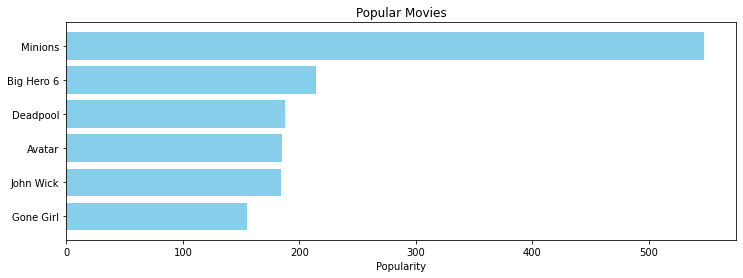

In [ ]:
pop= movies_links.sort_values('popularity', ascending=False)
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

In [ ]:
s = movies.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = movies.drop('genres', axis=1).join(s)

In [ ]:
md_year = pd.DataFrame(gen_md.groupby('release_date').original_title.nunique())
md_year.head()

,original_title
release_date,
1874-12-09,1
1878-06-14,1
1883-11-19,1
1887-08-18,1
1888-01-01,1


In [ ]:
md_year.nlargest(5,'original_title')

,original_title
release_date,
2008-01-01,136
2009-01-01,121
2007-01-01,117
2005-01-01,111
2006-01-01,101


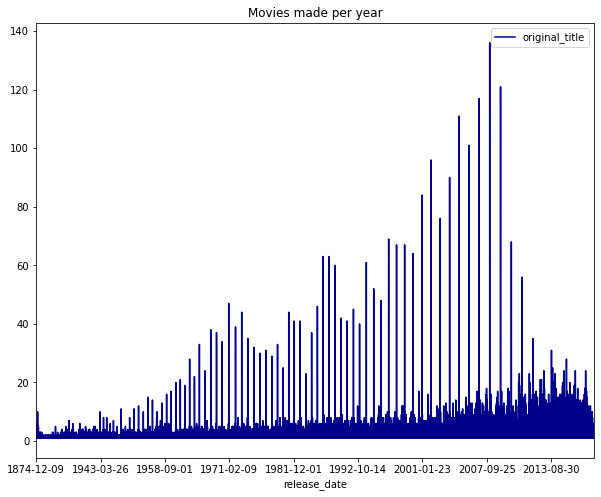

In [ ]:
md_year.plot.line(title = 'Movies made per year',color='DarkBlue',figsize=(10, 8));

In [ ]:
md_genre = (pd.DataFrame(gen_md.groupby('genre').original_title.nunique())).sort_values('original_title', ascending=True)
md_genre.head(20)

,original_title
genre,
TV Movie,764
Western,1021
War,1308
History,1374
Music,1567
Foreign,1615
Animation,1919
Fantasy,2219
Mystery,2405


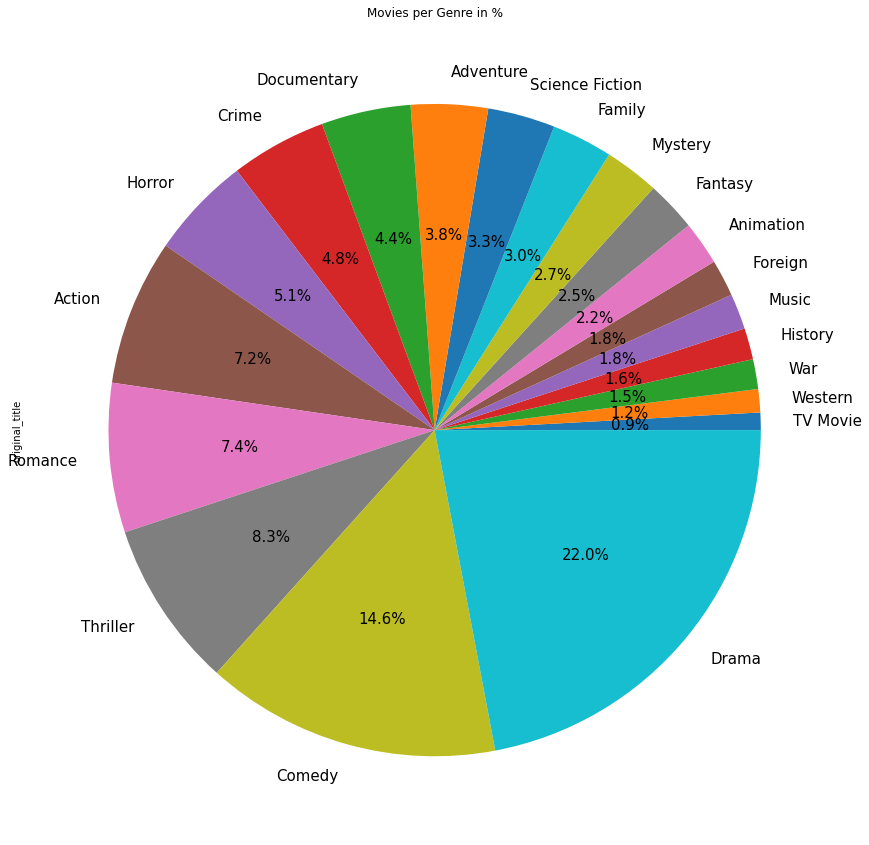

In [ ]:
md_genre['original_title'].plot.pie(title= 'Movies per Genre in %', figsize=(15,15), autopct='%1.1f%%',fontsize=15);

In [ ]:
md_year_mean = gen_md.groupby('release_date').mean()
md_year_mean.head(3)

,id,revenue,runtime,vote_average,vote_count
release_date,,,,,
1874-12-09,315946.0,0.0,1.0,6.0,19.0
1878-06-14,194079.0,0.0,1.0,6.2,25.0
1883-11-19,426903.0,0.0,1.0,5.4,7.0


In [ ]:
md_year_mean.nlargest(5,'vote_count')

,id,revenue,runtime,vote_average,vote_count
release_date,,,,,
2015-04-22,99861.000000,1.405404e+09,141.000000,7.30,6908.000000
2016-02-09,329346.000000,4.698678e+08,104.000000,5.76,6867.800000
2015-05-13,161684.166667,2.525766e+08,116.333333,7.30,6445.666667
2008-06-22,10681.000000,5.213119e+08,98.000000,7.80,6439.000000
2012-11-26,70785.750000,7.658277e+08,149.250000,6.85,6324.000000


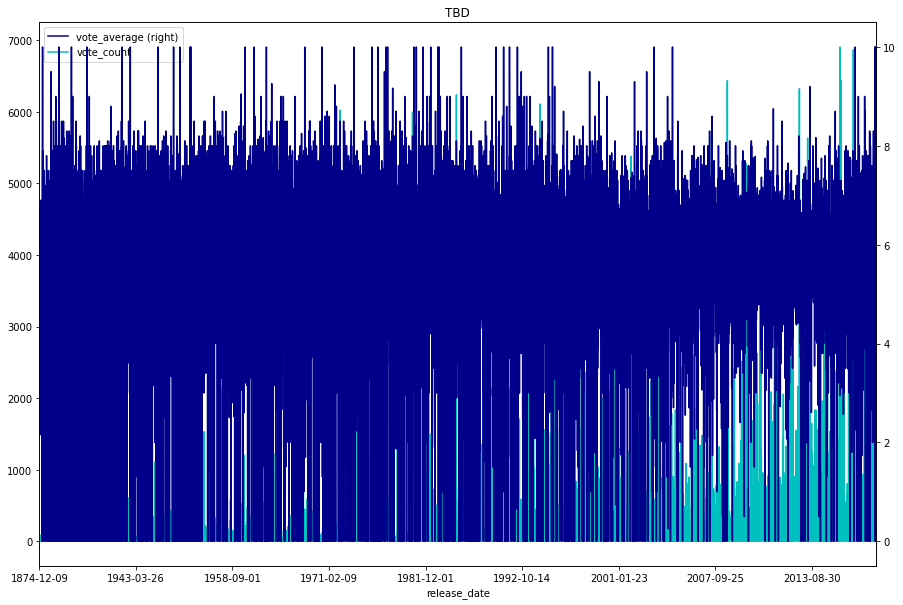

In [ ]:
md_year_mean[['vote_average', 'vote_count']].plot(title = 'TBD',color=('DarkBlue','c'),figsize=(15, 10),secondary_y=['vote_average']);

In [ ]:
movies.corr(method='pearson')

,id,revenue,runtime,vote_average,vote_count
id,1.000000,-0.071263,-0.121399,-0.167573,-0.064903
revenue,-0.071263,1.000000,0.103917,0.083868,0.812022
runtime,-0.121399,0.103917,1.000000,0.158146,0.113539
vote_average,-0.167573,0.083868,0.158146,1.000000,0.123607
vote_count,-0.064903,0.812022,0.113539,0.123607,1.000000


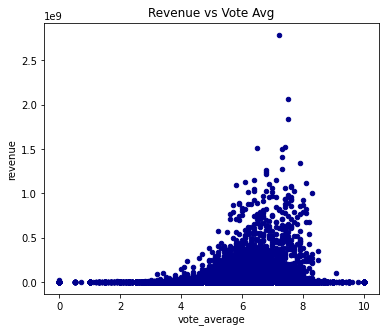

In [ ]:
movies.plot.scatter(x='vote_average', y='revenue',title='Revenue vs Vote Avg',color='DarkBlue',figsize=(6,5));

### **CONTENT RECOMMENDER 1**

In [ ]:
movies_links['tagline'] = movies_links['tagline'].fillna('')
movies_links['description'] = movies_links['overview'] + movies_links['tagline']
movies_links['description'] = movies_links['description'].fillna('')

In [ ]:
movies_links['description']

0        Led by Woody, Andy's toys live happily in his ...
1        When siblings Judy and Peter discover an encha...
2        A family wedding reignites the ancient feud be...
3        Cheated on, mistreated and stepped on, the wom...
4        Just when George Banks has recovered from his ...
                               ...                        
40224    From the mind behind Evangelion comes a hit la...
40503    The band stormed Europe in 1963, and, in 1964,...
44821    When Molly Hale's sadness of her father's disa...
44826    All your favorite Pokémon characters are back,...
45265    While holidaying in the French Alps, a Swedish...
Name: description, Length: 9099, dtype: object

In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies_links['description'])

In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix)

In [ ]:
cosine_sim

array([[1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
        0.        ],
       [0.00680476, 1.        , 0.01531062, ..., 0.00357057, 0.00762326,
        0.        ],
       [0.        , 0.01531062, 1.        , ..., 0.        , 0.00286535,
        0.00472155],
       ...,
       [0.        , 0.00357057, 0.        , ..., 1.        , 0.07811616,
        0.        ],
       [0.00344913, 0.00762326, 0.00286535, ..., 0.07811616, 1.        ,
        0.        ],
       [0.        , 0.        , 0.00472155, ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
movies_links.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,description
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.7,5415.0,1995,"Led by Woody, Andy's toys live happily in his ..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,When siblings Judy and Peter discover an encha...
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,A family wedding reignites the ancient feud be...
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"Cheated on, mistreated and stepped on, the wom..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,Just when George Banks has recovered from his ...


In [ ]:
movies_links = movies_links.reset_index()
titles = movies_links['title']
indices = pd.Series(movies_links.index, index=movies_links['title'])

In [ ]:
titles

0                                               Toy Story
1                                                 Jumanji
2                                        Grumpier Old Men
3                                       Waiting to Exhale
4                             Father of the Bride Part II
                              ...                        
9094                                        Shin Godzilla
9095    The Beatles: Eight Days a Week - The Touring Y...
9096                        Pokémon: Spell of the Unknown
9097          Pokémon 4Ever: Celebi - Voice of the Forest
9098                                        Force Majeure
Name: title, Length: 9099, dtype: object

In [ ]:
def content_recommendations1(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores,key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [ ]:
content_recommendations1('The Godfather').head(10)

973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
Name: title, dtype: object

In [ ]:
content_recommendations1('Batman: Under the Red Hood').head(10)

1113                             Batman Returns
7931                      The Dark Knight Rises
2579               Batman: Mask of the Phantasm
8227    Batman: The Dark Knight Returns, Part 2
524                                      Batman
8165    Batman: The Dark Knight Returns, Part 1
6144                              Batman Begins
6900                            The Dark Knight
8917         Batman v Superman: Dawn of Justice
466                   Robin Hood: Men in Tights
Name: title, dtype: object

***THE SECOND CONTENT RECOMMENDER***

In [ ]:
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')

In [ ]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
movies['id'] = movies['id'].astype('int')

In [ ]:
movies.shape

(45463, 25)

In [ ]:
movies = movies.merge(credits, on='id')
movies = movies.merge(keywords, on='id')

In [ ]:
movies_links = movies[movies['id'].isin(links_small)]
movies_links.shape

(9219, 28)

In [ ]:
movies_links['cast'] = movies_links['cast'].apply(literal_eval)
movies_links['crew'] = movies_links['crew'].apply(literal_eval)
movies_links['keywords'] = movies_links['keywords'].apply(literal_eval)
movies_links['cast_size'] = movies_links['cast'].apply(lambda x: len(x))
movies_links['crew_size'] = movies_links['crew'].apply(lambda x: len(x))

In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
movies_links['director'] = movies_links['crew'].apply(get_director)

In [ ]:
movies_links['cast'] = movies_links['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_links['cast'] = movies_links['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [ ]:
movies_links['keywords'] = movies_links['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [ ]:
movies_links['cast'] = movies_links['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
movies_links['director'] = movies_links['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
movies_links['director'] = movies_links['director'].apply(lambda x: [x,x, x])

In [ ]:
movies_links.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy, friendship, friends, riva...",13,106,"[johnlasseter, johnlasseter, johnlasseter]"


In [ ]:
s = movies_links.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [ ]:
s = s.value_counts()
sd = pd.DataFrame(s)

In [ ]:
sd.head(10)

,keyword
independent film,610
woman director,550
murder,399
duringcreditsstinger,327
based on novel,318
violence,264
love,222
sex,219
musical,219
suspense,212


In [ ]:
s = s[s > 1]

In [ ]:
lemman = WordNetLemmatizer()

In [ ]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [ ]:
movies_links['keywords'] = movies_links['keywords'].apply(filter_keywords)
movies_links['keywords'] = movies_links['keywords'].apply(lambda x: [lemman.lemmatize(i) for i in x])
movies_links['keywords'] = movies_links['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
movies_links['combo'] = movies_links['keywords'] + movies_links['cast'] + movies_links['director'] + movies_links['genres']
movies_links['combo'] = movies_links['combo'].apply(lambda x: ' '.join(x))

In [ ]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
bow = count.fit_transform(movies_links['combo'])

In [ ]:
cosine_sim = cosine_similarity(bow)

In [ ]:
movies_links = movies_links.reset_index()
titles = movies_links['title']
indices = pd.Series(movies_links.index, index=movies_links['title'])

In [ ]:
def content_recommendations2(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movie = movies_links.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movie[movie['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movie[movie['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    def weighted_rating(x):
        v = x['vote_count']
        R = x['vote_average']
        return (v/(v+m) * R) + (m/(m+v) * C)
    qualified = movie[(movie['vote_count'] >= m) & (movie['vote_count'].notnull()) & (movie['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [ ]:
content_recommendations2('Inception')

,title,vote_count,vote_average,year,wr
6981,The Dark Knight,12269,8,2008,7.712595
8613,Interstellar,11187,8,2014,7.689206
6623,The Prestige,4510,8,2006,7.375650
3381,Memento,4168,8,2000,7.341628
8031,The Dark Knight Rises,9263,7,2012,6.822018
6218,Batman Begins,7511,7,2005,6.789601
4173,Minority Report,2663,7,2002,6.575815
7286,X-Men Origins: Wolverine,4086,6,2009,6.013614
8207,Looper,4777,6,2012,6.012248
7903,Green Lantern,2551,5,2011,5.470580


In [ ]:
content_recommendations2('Mean Girls')

,title,vote_count,vote_average,year,wr
1547,The Breakfast Club,2189,7,1985,6.753897
390,Dazed and Confused,588,7,1993,6.369346
8883,The DUFF,1372,6,2015,5.884127
3712,The Princess Diaries,1063,6,2001,5.860251
4763,Freaky Friday,919,6,2003,5.845406
6277,Just Like Heaven,595,6,2005,5.796851
6959,The Spiderwick Chronicles,593,6,2008,5.796457
7494,American Pie Presents: The Book of Love,454,5,2009,5.254920
7332,Ghosts of Girlfriends Past,716,5,2009,5.196974
7905,Mr. Popper's Penguins,775,5,2011,5.187382


***COLABORATIVE FILTERING***

In [ ]:
reader = Reader()

In [ ]:
ratings = pd.read_csv('ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
gb = ratings.groupby(['userId','movieId'])
gb.apply(lambda _df: _df.sort_values(by=['rating']))

userId  movieId  rating   timestamp
userId movieId                                            
1      31      0            1       31     2.5  1260759144
       1029    1            1     1029     3.0  1260759179
       1061    2            1     1061     3.0  1260759182
       1129    3            1     1129     2.0  1260759185
       1172    4            1     1172     4.0  1260759205
...                       ...      ...     ...         ...
671    6268    99999      671     6268     2.5  1065579370
       6269    100000     671     6269     4.0  1065149201
       6365    100001     671     6365     4.0  1070940363
       6385    100002     671     6385     2.5  1070979663
       6565    100003     671     6565     3.5  1074784724

[100004 rows x 4 columns]

In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=10, verbose=True)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8901  0.8937  0.8925  0.8966  0.8943  0.9017  0.8830  0.8809  0.9023  0.8901  0.8925  0.0066  
MAE (testset)     0.6832  0.6866  0.6882  0.6879  0.6899  0.6942  0.6791  0.6788  0.6931  0.6832  0.6864  0.0051  
Fit time          6.45    6.21    6.38    6.19    6.35    6.15    6.28    6.15    6.28    6.15    6.26    0.10    
Test time         0.08    0.08    0.09    0.09    0.08    0.08    0.09    0.08    0.08    0.08    0.08    0.00    
Evaluating RMSE, MAE of algorithm SlopeOne on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9306  0.9150  0.9110  0.9163  0.9172  0.9357  0.9297  0.9202  0.9253  0.9256  0.9227  0.0076  
MAE (testset)     0.7122  0.7048  0.6999  0.7066  0.7021  0.7144  0.7103  0.7020

In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,0.892530,0.686416,6.259782,0.081119
KNNWithZScore,0.911768,0.694166,0.323445,1.144097
KNNWithMeans,0.913978,0.699352,0.271922,1.070251
SlopeOne,0.922666,0.706577,6.097675,4.290388
NMF,0.939757,0.721992,7.417694,0.067075
CoClustering,0.957840,0.742924,3.247052,0.059564
KNNBasic,0.960549,0.738561,0.228864,1.084020
NormalPredictor,1.435145,1.144720,0.188878,0.106576


In [ ]:
bench=pd.DataFrame(benchmark).sort_values('test_rmse')

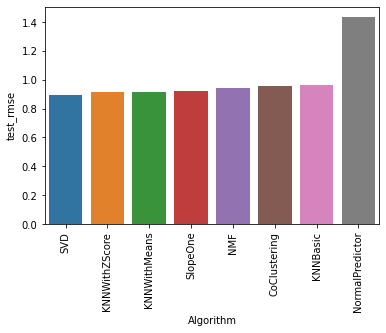

In [ ]:
sns.barplot(x='Algorithm',y='test_rmse',data=bench,label="Number of Words")
plt.xticks(rotation=90)
plt.show()

In [ ]:
trainset = data.build_full_trainset()

svd = SVD()
svd.fit(trainset)

In [ ]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.621714544889115, details={'was_impossible': False})

In [ ]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [ ]:
id_map = pd.read_csv('links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(movies_links[['title', 'id']], on='id').set_index('title')

In [ ]:
indices_map = id_map.set_index('id')

In [ ]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = movies_links.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [ ]:
hybrid(1, 'Avatar')

,title,vote_count,vote_average,year,id,est
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,3.134840
1011,The Terminator,4208.0,7.4,1984,218,3.078559
974,Aliens,3282.0,7.7,1986,679,3.011681
1668,Return from Witch Mountain,38.0,5.6,1978,14822,2.864024
8401,Star Trek Into Darkness,4479.0,7.4,2013,54138,2.858307
8658,X-Men: Days of Future Past,6155.0,7.5,2014,127585,2.834193
4347,Piranha Part Two: The Spawning,41.0,3.9,1981,31646,2.762800
7088,Star Wars: The Clone Wars,434.0,5.8,2008,12180,2.723354
344,True Lies,1138.0,6.8,1994,36955,2.718713
922,The Abyss,822.0,7.1,1989,2756,2.682760


In [ ]:
hybrid(500, 'Avatar')

,title,vote_count,vote_average,year,id,est
8658,X-Men: Days of Future Past,6155.0,7.5,2014,127585,3.476465
8401,Star Trek Into Darkness,4479.0,7.4,2013,54138,3.369692
1668,Return from Witch Mountain,38.0,5.6,1978,14822,3.276212
974,Aliens,3282.0,7.7,1986,679,3.213096
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,3.091681
4347,Piranha Part Two: The Spawning,41.0,3.9,1981,31646,3.076059
4966,Hercules in New York,63.0,3.7,1969,5227,3.028708
2132,Superman II,642.0,6.5,1980,8536,2.974965
1011,The Terminator,4208.0,7.4,1984,218,2.964480
3181,The Time Machine,217.0,7.5,1960,2134,2.954621


In [ ]:
hybrid(1, 'Aliens')

,title,vote_count,vote_average,year,id,est
987,Alien,4564.0,7.9,1979,348,3.248485
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,3.134840
1011,The Terminator,4208.0,7.4,1984,218,3.078559
7498,Daybreakers,646.0,6.0,2009,19901,2.862016
6967,Doomsday,374.0,5.8,2008,13460,2.784120
4347,Piranha Part Two: The Spawning,41.0,3.9,1981,31646,2.762800
7828,I Am Number Four,1606.0,5.9,2011,46529,2.748777
3935,Impostor,136.0,6.1,2001,4965,2.745700
344,True Lies,1138.0,6.8,1994,36955,2.718713
6640,Déjà Vu,1519.0,6.6,2006,7551,2.698418


In [ ]:
hybrid(500, 'Aliens')

,title,vote_count,vote_average,year,id,est
7939,Gantz,73.0,6.5,2011,56832,3.431684
6640,Déjà Vu,1519.0,6.6,2006,7551,3.154371
522,Terminator 2: Judgment Day,4274.0,7.7,1991,280,3.091681
7948,Stake Land,290.0,6.2,2010,52015,3.077738
4347,Piranha Part Two: The Spawning,41.0,3.9,1981,31646,3.076059
7498,Daybreakers,646.0,6.0,2009,19901,3.074055
8042,The Darkest Hour,474.0,4.8,2011,71469,3.000285
987,Alien,4564.0,7.9,1979,348,2.974652
1011,The Terminator,4208.0,7.4,1984,218,2.964480
7488,Avatar,12114.0,7.2,2009,19995,2.963851
